# Imports

In [1]:
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import requests
import os
import pdfkit 
import urllib
import time
import selenium
from selenium import webdriver
import datetime
from tqdm import tqdm_notebook

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torchvision.utils as vutils

import cv2

# Parsing

## Create df

In [2]:
def get_date(d):
    if d.month<10:
        month = f'0{d.month}'
    else:
        month = month = f'{d.month}'
    if d.day <10:
        day = f'0{d.day}'
    else:
        day = f'{d.day}'
    return f'{d.year}{month}{day}'

In [3]:
d = datetime.date(2020, 3, 27)
sub = datetime.timedelta(7)
d = d+sub
page = 'https://www.allmusic.com/newreleases/all/'

In [ ]:
driver = webdriver.Chrome('C:\\Users\\Абылайхан\\Desktop\\Py\\Selenium\\chromedriver.exe')

In [ ]:
artist = []
album = []
label = []
genre = []
url = []
for j in tqdm_notebook(range(200)):
    d = d - sub
    date = get_date(d)
    req = page+date
    driver.get(req)
    time.sleep(0.3)
    content = driver.page_source
    table = bs(content).find_all('tr')
    for i in table[1:-1]:
        temp = i.find_all('td')
        artist.append(temp[0]['data-sort-value'])
        album.append(temp[1]['data-sort-value'][0:-len(temp[0]['data-sort-value'])-1])               
        label.append(temp[2]['data-sort-value'][0:-len(temp[0]['data-sort-value'])-1])               
        genre.append(temp[3]['data-sort-value'][0:-len(temp[0]['data-sort-value'])-1])               
        url.append(temp[1].find('a')['href'])        


In [ ]:
df = pd.DataFrame({
    'artist': artist,
    'album': album,
    'label': label,
    'genre': genre,
    'url': url
})
df = df.drop_duplicates()
df.to_csv('songs.csv', index = False)

## Saving images

In [ ]:
df = pd.read_csv('songs.csv')

In [ ]:
driver = webdriver.Chrome('C:\\Users\\Абылайхан\\Desktop\\Py\\Selenium\\chromedriver.exe')

In [ ]:
#helps to strart from checkpoint
maxim = 0
for i in os.listdir('covers'):
    temp = int(i[:-4])
    if temp>maxim:
        maxim = temp

In [ ]:
for i in tqdm_notebook(range(len(df.iloc[maxim+1:,:]))):
    try:
        driver.get(df.url[i+maxim+1])
        link = bs(driver.page_source).find('div', {'class':"album-contain"}).find('img')['src']
        if link == '//cdn-gce.allmusic.com/images/no_image/album_300x300.png':
            continue
        urllib.request.urlretrieve(link, f'covers/{i+maxim+1}.png')
    except Exception as e:
        print(e)

# Model

In [2]:
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
image_size = 512

In [3]:
workers= 0
batch_size = 2
dataset = datasets.ImageFolder(root='../covers',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((123, 116, 103), (58, 57, 57)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(ngf*2),
            nn.ConvTranspose2d( ngf*2, ngf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(ngf),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nc),
            nn.ConvTranspose2d( nc, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, ndf*16, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 16),
            nn.Conv2d(ndf*16, ndf * 8, 5, 2, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 8),
            nn.Conv2d(ndf*8, ndf * 4, 4, 2, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 4),
            nn.Conv2d(ndf*4, 1, 4, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
gen = Generator()
dis = Discriminator()
weights_init(gen)
weights_init(dis)
gen.cuda();
dis.cuda();

In [8]:
loss_BCE = nn.BCELoss()

optimizerD = optim.Adam(dis.parameters(), lr=0.005, betas=(0.9, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=0.005, betas=(0.9, 0.999))

In [9]:
num_epochs = 10
img_list = []
G_losses = []
D_losses = []
iters = 0
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
for epoch in tqdm_notebook(range(num_epochs)):
    for i, data in enumerate(dataloader, 0):
        dis.zero_grad()
        images = data[0].to(device).float()
        labels = torch.full((images.shape[0],), 1, device=device)
        output = dis(images).view(-1)
        loss_dis_real =loss_BCE(output, labels)
        loss_dis_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = gen(noise)
        labels = torch.full((2,), 0, device=device)
        output = dis(fake.detach()).view(-1)
        loss_dis_fake = loss_BCE(output, labels)
        loss_dis_fake.backward()
        D_G_z1 = output.mean().item()
        loss_dis = loss_dis_fake+ loss_dis_real
        optimizerD.step()
        
        gen.zero_grad()
        labels.fill_(1)
        output = dis(fake).view(-1)
        loss_gen = loss_BCE(output, labels)
        loss_gen.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     loss_dis.item(), loss_gen.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(loss_gen.item())
        D_losses.append(loss_dis.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/10][0/259]	Loss_D: 1.6063	Loss_G: 31.3355	D(x): 0.5087	D(G(z)): 0.5872 / 0.0000
[0/10][50/259]	Loss_D: 0.0547	Loss_G: 13.4232	D(x): 0.9999	D(G(z)): 0.0518 / 0.0308


KeyboardInterrupt: 

In [18]:
torch.randn(batch_size, nz, 1, 1, device=device).shape

torch.Size([2, 100, 1, 1])

In [ ]:
gen.load_state_dict(torch.load('gen'))
dis.load_state_dict(torch.load('dis'))

In [28]:
torch.save(gen.state_dict(), 'gen')
torch.save(dis.state_dict(), 'dis')

In [26]:
# gen.eval()
a = gen.cpu()(torch.randn(64, nz, 1, 1, device=device).cpu())

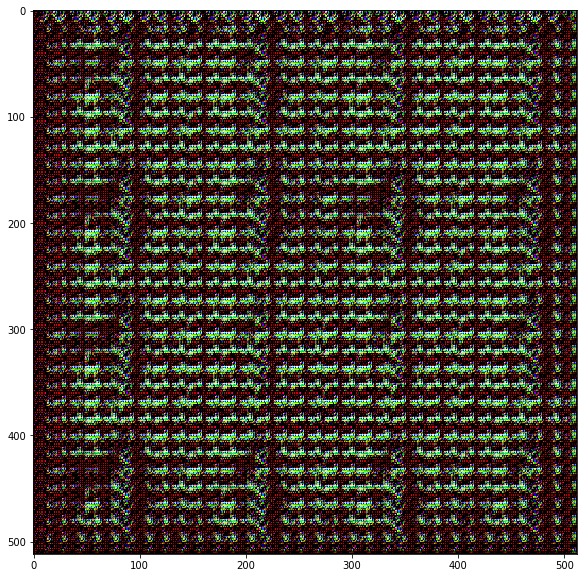

In [27]:
plt.figure(figsize = (10,10))
test = a[6].permute(1,2,0).detach().numpy()
test = test -test.min()
test = test/test.max()
plt.imshow(test)

In [20]:
gen.train();

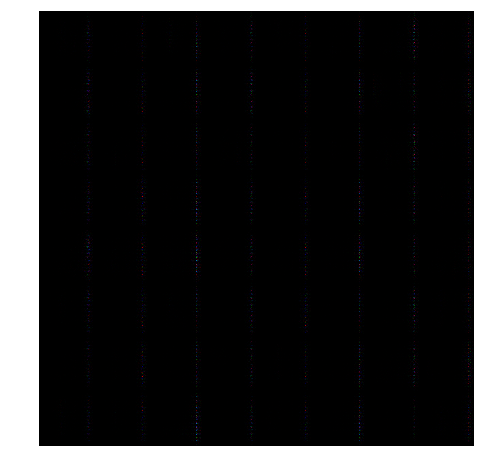

In [35]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())